In [1]:
import random
import torch
import torch.nn.functional as F
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%env KMP_DUPLICATE_LIB_OK=TRUE # fixed my kernel dead

env: KMP_DUPLICATE_LIB_OK=TRUE # fixed my kernel dead


# Data

In [3]:
words = open("names.txt", 'r').read().split()

In [4]:
# characters mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build data set with mini batch
random.seed(49)
random.shuffle(words)

block_size = 3 # context length: how many previous characters do we take to predict the next char?
X, y = [], []

for w in words:
    context = [0] * block_size
    chrs = list(w) + ['.']
    for ch in chrs:
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        # print(  ''.join(itos[i] for i in context) + '--->' + itos[ix] )
        context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)

n1 = int(len(X)*0.8)
n2 = int(len(X)*0.9)

X_train, y_train = X[:n1], y[:n1]
X_val, y_val = X[n1:n2], y[n1:n2]
X_test, y_test = X[n2:], y[n2:]

In [6]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([182516, 3]) torch.Size([182516])
torch.Size([22815, 3]) torch.Size([22815])
torch.Size([22815, 3]) torch.Size([22815])


# Classes same API as nn.Module in Pytorch

In [7]:
class Linear:
    
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features)) / in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None
    
    def __call__(self, X):
        self.out = X @ self.weight
        if self.bias is not None : self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [8]:
class BatchNorm1d:
    def __init__(self, n_hidden, eps=1e-5, momentum=0.1):
        self.training = True
        self.momentum = momentum
        self.eps = eps
        # batch parameters
        self.gamma = torch.ones((1, n_hidden))
        self.beta = torch.zeros((1, n_hidden))
        # buffers train with running momentum update
        self.moving_mean = torch.zeros((1, n_hidden))
        self.moving_var = torch.ones((1, n_hidden))
        
    def __call__(self, x):
        if self.training:
            bn_mean = x.mean(axis=0, keepdims=True)
            bn_var = x.var(axis=0, keepdims=True)
        else:
            bn_mean = self.moving_mean 
            bn_var = self.moving_var
        # batch norm    
        bn_hat = (x - bn_mean) / torch.sqrt(bn_var + self.eps)
        self.out = self.gamma * bn_hat + self.beta
        
        # update momentum buffers
        if self.training:
            with torch.no_grad():
                self.moving_mean = (1-self.momentum) * self.moving_mean + self.momentum * bn_mean
                self.moving_vari = (1-self.momentum) * self.moving_var + self.momentum * bn_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [9]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [25]:
torch.manual_seed(49)
n_embd = 10 # dim of the character embedding vectors
in_features = n_embd * block_size
n_hidden = 100 # n of neuron hidden layer

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(in_features, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(   n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(   n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(   n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(   n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear( n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

# layers = [
#     Linear(in_features, n_hidden, bias=False), Tanh(),
#     Linear(   n_hidden, n_hidden, bias=False), Tanh(),
#     Linear(   n_hidden, n_hidden, bias=False), Tanh(),
#     Linear(   n_hidden, n_hidden, bias=False), Tanh(),
#     Linear(   n_hidden, n_hidden, bias=False), Tanh(),
#     Linear( n_hidden, vocab_size, bias=False)
# ]

with torch.no_grad():
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("number of parameters: {}".format(sum([p.nelement() for p in parameters])))

# set require grad
for p in parameters:
    p.requires_grad = True

number of parameters: 47024


In [26]:
epochs = 1000
batch_size = 32
loss_i = []
grad_i = []

In [27]:
torch.manual_seed(49)

for i in tqdm_notebook(range(epochs+1)):
    
    # set mini batch 
    ix = torch.randint(0, len(X_train)+1, (32, ))
    Xb, yb = X_train[ix], y_train[ix]
    
    # forward pass
    embd = C[Xb]
    x = embd.view(-1, in_features) # concate embd vector
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x , yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update step
    lr = 1e-1 if i <= epochs/2 else 1e-2
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stat
    if i % 1000 == 0:
        print(f"{i} / {epochs}: {loss.item():.4f}")
    loss_i.append(loss.item())

C:\Users\bJ5xp\AppData\Local\Temp\ipykernel_27284\1547471799.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs+1)):


  0%|          | 0/1001 [00:00<?, ?it/s]

0 / 1000: 3.4947
1000 / 1000: 2.3499


layer 2 (Tanh): mean -0.01, std 0.62, saturated 3.55%
layer 5 (Tanh): mean +0.00, std 0.63, saturated 2.72%
layer 8 (Tanh): mean +0.00, std 0.64, saturated 1.41%
layer 11 (Tanh): mean +0.00, std 0.64, saturated 1.75%
layer 14 (Tanh): mean +0.00, std 0.64, saturated 2.00%


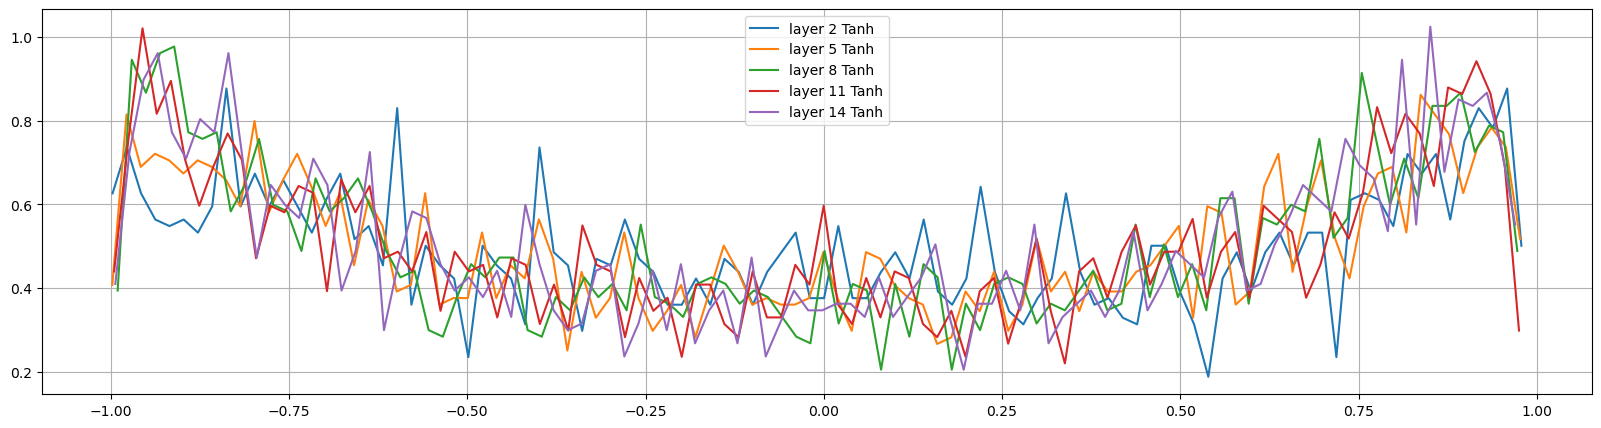

In [28]:
plt.figure(figsize=(20,5))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        name = layer.__class__.__name__
        pct_sat = (t.abs() >= 0.98).sum() / t.abs().sum() *100
        print("layer %d (%s): mean %+.2f, std %.2f, saturated %.2f%%"%(i, name, t.mean(), t.std(), pct_sat))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {name}')
plt.legend(legends);
plt.grid();

layer 2 (Tanh): mean +0.00, std 3.413577e-03
layer 5 (Tanh): mean +0.00, std 2.906538e-03
layer 8 (Tanh): mean +0.00, std 2.765610e-03
layer 11 (Tanh): mean -0.00, std 2.808695e-03
layer 14 (Tanh): mean +0.00, std 2.805853e-03


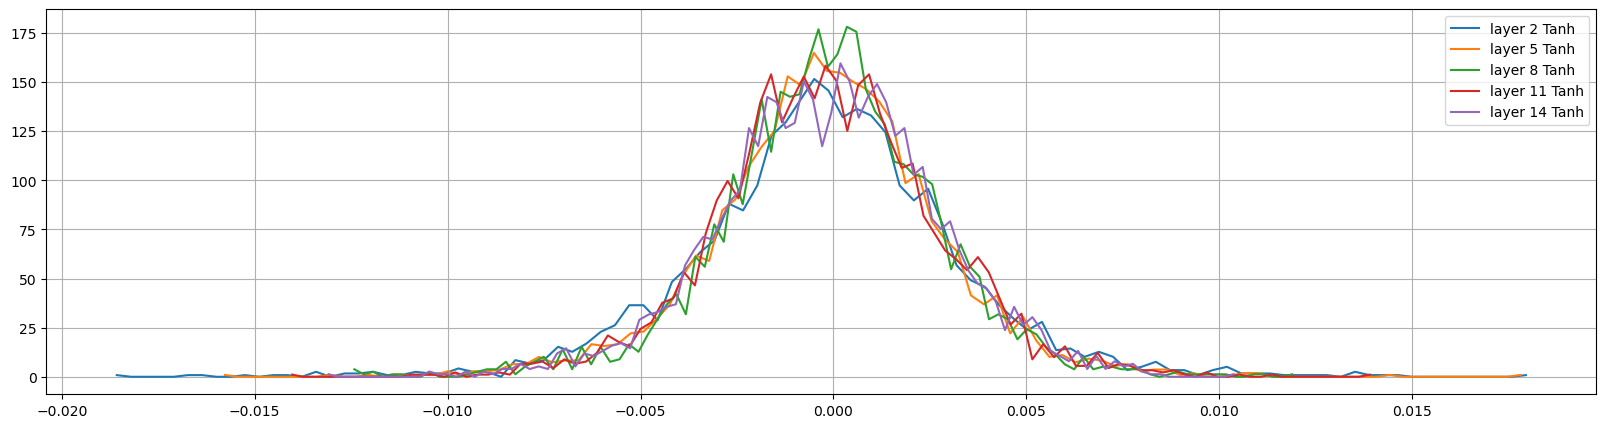

In [29]:
plt.figure(figsize=(20,5))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        name = layer.__class__.__name__
        print("layer %d (%s): mean %+.2f, std %e"%(i, name, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {name}')
plt.legend(legends);
plt.grid();